In [1]:
import pandas as pd
import string
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
loans = pd.read_csv('lending-club-data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans', axis=1,inplace=True)

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]


In [5]:
num_rows_with_na = loans.shape[0]
loans = loans[[target] + features].dropna()

# Count the number of rows with missing data

num_rows = loans.shape[0]
print ('Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows))

Dropping 122607 observations; keeping 122578 


In [6]:
train_idx = pd.read_json('module-8-assignment-1-train-idx.json')
validation_idx = pd.read_json('module-8-assignment-1-validation-idx.json')
train_data = loans.iloc[train_idx[0].to_numpy()]
validation_data_e = loans.iloc[validation_idx[0].to_numpy()]

In [7]:
train_data_objects = train_data.select_dtypes(['object'])
object_columns_train = train_data_objects.columns.values
train_data = pd.get_dummies(train_data, columns=object_columns_train, drop_first=False)
features_train = train_data.columns.values
features_train = np.delete(features_train, 0)
features_train

array(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_small_business', 'purpose_vacation',
       'purpose_wedding'], dtype=object)

In [9]:
validation_data_objects = validation_data_e.select_dtypes(['object'])
object_columns_validation = validation_data_objects.columns.values
validation_data = pd.get_dummies(validation_data_e, columns=object_columns_validation, drop_first=False) 
features_validation = validation_data.columns.values
features_validation = np.delete(features_validation, 0)
features_validation

array(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_small_business', 'purpose_vacation',
       'purpose_wedding'], dtype=object)

In [10]:
validation_data.shape

(9284, 45)

In [11]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [12]:
X_train=train_data[features_train]
y_train=train_data[target]
model_5 = GradientBoostingClassifier(max_depth=6 ,n_estimators=5)
model_5.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
model_5.predict(sample_validation_data[features_validation])

array([ 1,  1, -1,  1], dtype=int64)

In [14]:
model_5.predict_proba(sample_validation_data[features_validation])

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

In [15]:
model_5.score(validation_data[features_validation],validation_data[target])

0.6614605773373546

In [16]:
y_true = validation_data[target]
y_pred = model_5.predict(validation_data[features_validation])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fp

1652

In [17]:
fn

1491

In [18]:
cost = 10000 * fn  + 20000 * fp
cost

47950000

In [19]:
validation_data.shape

(9284, 45)

In [38]:
probability_predictions = model_5.predict_proba(validation_data[features_validation])
probability_predictions

array([[0.53807792, 0.46192208],
       [0.39591639, 0.60408361],
       [0.52012758, 0.47987242],
       ...,
       [0.53530977, 0.46469023],
       [0.52280924, 0.47719076],
       [0.53807792, 0.46192208]])

In [39]:
validation_data['prediction_0'] = probability_predictions[:,0]
validation_data_e['prediction'] = probability_predictions[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#validation_data_e['prediction'] = pd.DataFrame(probability_predictions).apply(lambda x: x[0] if x[0]> x[1] else x[1], axis=1).values
    

In [41]:
validation_data_e[['grade','prediction']].sort_values(by='prediction', ascending=False)

,grade,prediction
8021,A,0.673059
92079,A,0.661468
68973,A,0.661468
19865,A,0.661468
19954,A,0.661468
...,...,...
101746,D,0.315969
84921,C,0.315969
27502,C,0.312806
84508,C,0.307334


In [42]:
validation_data_e[['grade','prediction']].sort_values(by='prediction', ascending=True)

,grade,prediction
58794,C,0.307334
84508,C,0.307334
27502,C,0.312806
114781,D,0.315969
101746,D,0.315969
...,...,...
57584,A,0.661468
13187,A,0.661468
4690,A,0.661468
44257,A,0.661468


In [36]:
model_10 = GradientBoostingClassifier(max_depth=6 ,n_estimators=10)
model_10.fit(train_data[features_train],train_data[target])
model_10.score(validation_data[features_validation],validation_data[target])

0.6664153382162861

In [37]:
model_50 = GradientBoostingClassifier(max_depth=6 ,n_estimators=50)
model_50.fit(train_data[features_train],train_data[target])
model_50.score(validation_data[features_validation],validation_data[target])

0.6844032744506678

In [26]:
model_100 = GradientBoostingClassifier(max_depth=6 ,n_estimators=100)
model_100.fit(train_data[features_train],train_data[target])
model_100.score(validation_data[features_validation],validation_data[target])

0.6907582938388626

In [27]:
model_200 = GradientBoostingClassifier(max_depth=6 ,n_estimators=200)
model_200.fit(train_data[features_train],train_data[target])
model_200.score(validation_data[features_validation],validation_data[target])

0.6895734597156398

In [28]:
model_500 = GradientBoostingClassifier(max_depth=6 ,n_estimators=500)
model_500.fit(train_data[features_train],train_data[target])
model_500.score(validation_data[features_validation],validation_data[target])

0.6892503231365791

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [30]:
train_err_10 = 1 - model_10.score(train_data[features_validation],train_data[target])
train_err_50 = 1 - model_50.score(train_data[features_validation],train_data[target])
train_err_100 = 1 - model_100.score(train_data[features_validation],train_data[target])
train_err_200 = 1 - model_200.score(train_data[features_validation],train_data[target])
train_err_500 = 1 - model_500.score(train_data[features_validation],train_data[target])

In [31]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

In [32]:
validation_err_10 = 1 - model_10.score(validation_data[features_validation],validation_data[target])
validation_err_50 = 1 - model_50.score(validation_data[features_validation],validation_data[target])
validation_err_100 = 1 - model_100.score(validation_data[features_validation],validation_data[target])
validation_err_200 = 1 - model_200.score(validation_data[features_validation],validation_data[target])
validation_err_500 = 1 - model_500.score(validation_data[features_validation],validation_data[target])

In [33]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

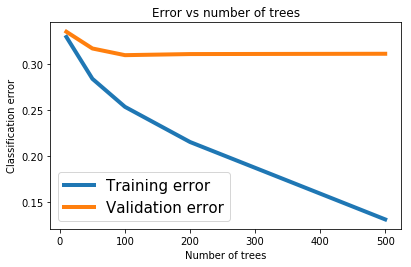

In [34]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')